# OpenSearch Hybrid Search Demo
**Pattern:** BM25 (lexical) + k-NN (semantic) with normalization pipeline

**Components:**
- Amazon OpenSearch Service
- BM25 keyword search
- k-NN vector search
- Hybrid query with score normalization
- Amazon Bedrock for embeddings

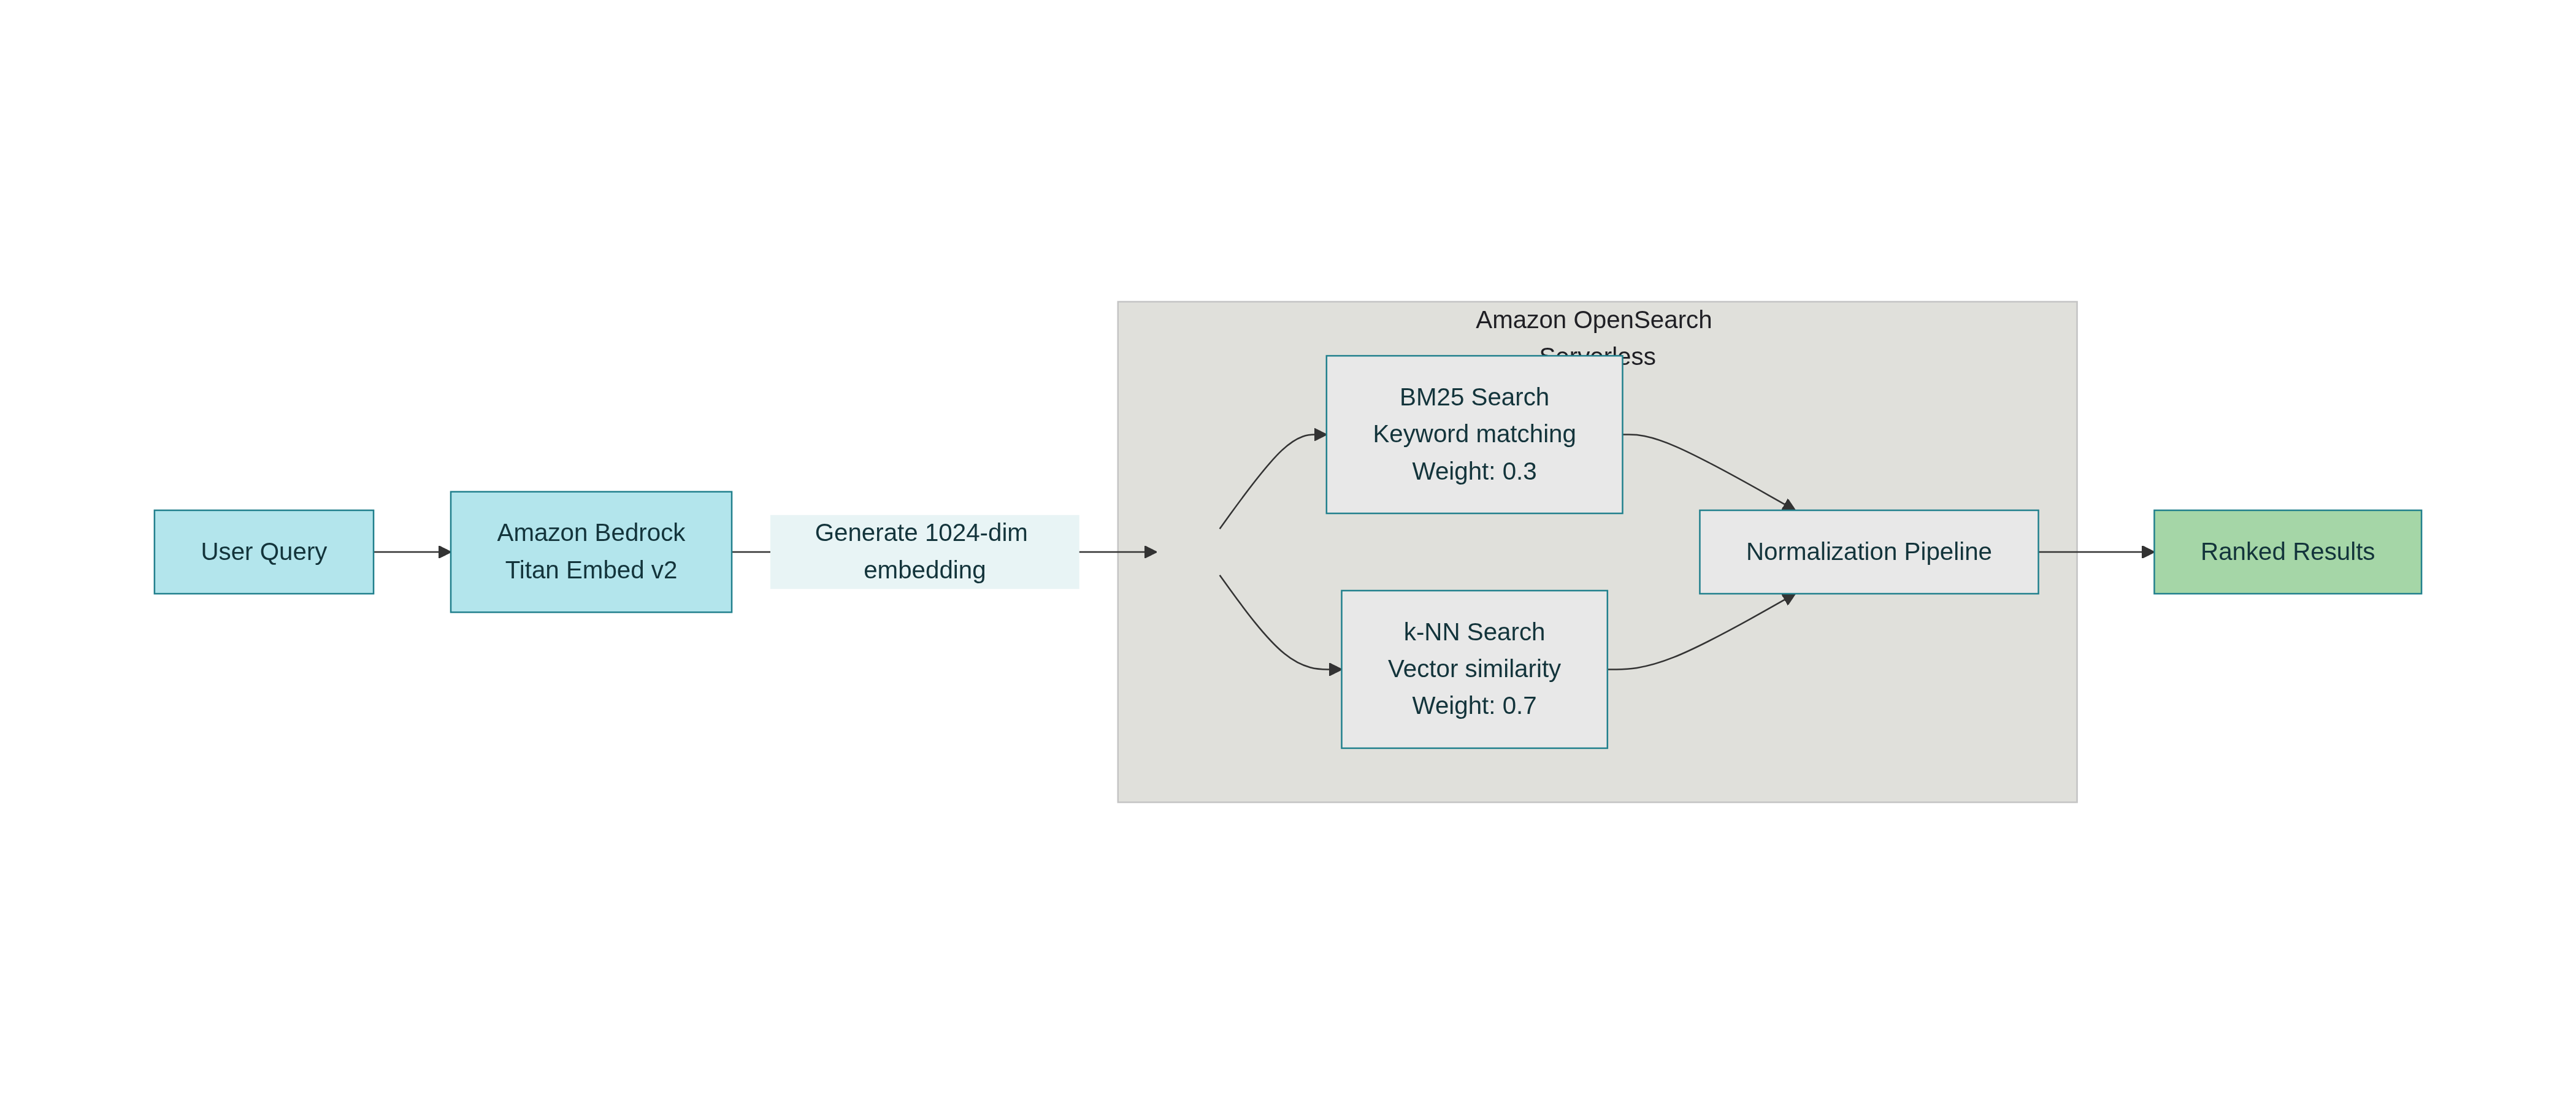

In [1]:
import boto3
import json
import time
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth
import numpy as np

In [2]:
client = boto3.client('opensearchserverless', region_name='us-east-1')

# Network policy (required)
client.create_security_policy(
    name='demo-network-policy',
    type='network',
    policy='[{"Rules":[{"ResourceType":"collection","Resource":["collection/hybrid-search-demo"]}],"AllowFromPublic":true}]'
)

# Data access policy (required)
client.create_access_policy(
    name='demo-data-policy',
    type='data',
    policy='[{"Rules":[{"ResourceType":"collection","Resource":["collection/hybrid-search-demo"],"Permission":["aoss:DescribeCollectionItems","aoss:CreateCollectionItems","aoss:UpdateCollectionItems","aoss:DeleteCollectionItems"]},{"ResourceType":"index","Resource":["index/hybrid-search-demo/*"],"Permission":["aoss:CreateIndex","aoss:UpdateIndex","aoss:DescribeIndex","aoss:ReadDocument","aoss:WriteDocument","aoss:DeleteIndex"]}],"Principal":["arn:aws:iam::058264544288:root"]}]'
)

ConflictException: An error occurred (ConflictException) when calling the CreateSecurityPolicy operation: Policy with name demo-network-policy and type network already exists

In [ ]:
# Create encryption policy (required)
client.create_security_policy(
    name='hybrid-search-demo-encryption',
    type='encryption',
    policy='{"Rules":[{"ResourceType":"collection","Resource":["collection/hybrid-search-demo"]}],"AWSOwnedKey":true}'
)

response = client.create_collection(
    name='hybrid-search-demo',
    type='VECTORSEARCH',
    vectorOptions={
        'ServerlessVectorAcceleration': 'ENABLED'
    }
    
)

print(f"Collection ARN: {response['createCollectionDetail']['arn']}")

In [3]:
response = client.batch_get_collection(names=['hybrid-search-demo'])
collection_id = response['collectionDetails'][0]['id']
endpoint = response['collectionDetails'][0]['collectionEndpoint']

print(f"Collection Endpotin: {endpoint}")

Collection Endpotin: https://y3ag6co7j6u9wwx1fkvi.us-east-1.aoss.amazonaws.com


In [11]:
# Configuration
REGION = 'us-east-1'
OPENSEARCH_ENDPOINT = endpoint.replace("https://", "")
INDEX_NAME = 'vector-index'
EMBEDDING_MODEL = 'amazon.titan-embed-text-v2:0'

# Initialize clients
bedrock_runtime = boto3.client('bedrock-runtime', region_name=REGION)

service = 'aoss'  # Important: use 'aoss' for serverless
region = 'us-east-1'
# Set up authentication
credentials = boto3.Session().get_credentials()
auth = AWSV4SignerAuth(credentials, region, service)

client_oss = OpenSearch(
    hosts=[{'host': 'y3ag6co7j6u9wwx1fkvi.us-east-1.aoss.amazonaws.com', 'port': 443}],
    http_auth=auth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    pool_maxsize=20
)

## 1. Setup Index with Vector and Text Fields

In [ ]:


index_body = {
    'settings': {
        'index.knn': True
    },
    'mappings': {
        'properties': {
            'vector': {
                'type': 'knn_vector',
                'dimension': 1024,
                'method': {
                    'engine': 'faiss',
                    'name': 'hnsw',
                    'space_type': 'cosinesimil'  # Use abbreviated form
                }
            },
            'text': {
                'type': 'text'
            }
        }
    }
}


index_name = 'vector-index'

response = client_oss.indices.create(index=index_name, body=index_body)
print(f"Index created: {response}")

## 2. Setup Hybrid Search Pipeline

In [12]:
def create_search_pipeline():
    """Create normalization pipeline for hybrid search"""
    pipeline_body = {
        "description": "Hybrid search normalization pipeline",
        "phase_results_processors": [
            {
                "normalization-processor": {
                    "normalization": {
                        "technique": "min_max"
                    },
                    "combination": {
                        "technique": "arithmetic_mean",
                        "parameters": {
                            "weights": [0.3, 0.7]  # BM25: 0.3, Vector: 0.7
                        }
                    }
                }
            }
        ]
    }
    
    pipeline_name = "hybrid_pipeline"
    response = client_oss.transport.perform_request(
        "PUT",
        f"/_search/pipeline/{pipeline_name}",
        body=pipeline_body
    )
    print(f"Created search pipeline: {pipeline_name}")
    return pipeline_name

pipeline_name = create_search_pipeline()

Created search pipeline: hybrid_pipeline


## 3. Document Processing and Indexing

In [13]:
def get_embedding(text: str) -> list:
    """Generate embedding using Bedrock"""
    response = bedrock_runtime.invoke_model(
        modelId=EMBEDDING_MODEL,
        body=json.dumps({"inputText": text})
    )
    return json.loads(response['body'].read())['embedding']

# Sample documents
documents = [
    {
        "title": "Vector Search Fundamentals",
        "content": "Vector search uses machine learning embeddings to find semantically similar content. It converts text into high-dimensional numerical representations.",
        "category": "AI"
    },
    {
        "title": "OpenSearch Hybrid Search", 
        "content": "Hybrid search combines BM25 keyword matching with k-NN vector similarity. This approach improves search relevance significantly.",
        "category": "Search"
    },
    {
        "title": "Amazon Bedrock Integration",
        "content": "Amazon Bedrock provides foundation models for embedding generation. It integrates seamlessly with OpenSearch for RAG applications.",
        "category": "AWS"
    },
    {
        "title": "Machine Learning Embeddings",
        "content": "Embeddings capture semantic meaning in numerical form. They enable similarity search based on context rather than exact keyword matches.",
        "category": "ML"
    },
    {
        "title": "Search Relevance Optimization",
        "content": "Combining lexical and semantic search methods creates more accurate results. Normalization techniques balance different scoring algorithms.",
        "category": "Optimization"
    }
]

def index_documents():
    """Index documents with embeddings"""
    for i, doc in enumerate(documents):
        # Generate embedding
        text_for_embedding = f"{doc['title']} {doc['content']}"
        embedding = get_embedding(text_for_embedding)
        
        # Prepare document
        doc_body = {
            **doc,
            "vector": embedding,
            "timestamp": "2024-01-01T00:00:00Z"
        }
        
        # Index document
        client.index(
            index=INDEX_NAME,
            body=doc_body
        )
    
    # Refresh index
    #client.indices.refresh(index=INDEX_NAME)
    print(f"Indexed {len(documents)} documents")

index_documents()

AttributeError: 'OpenSearchServiceServerless' object has no attribute 'index'

## 4. Search Functions

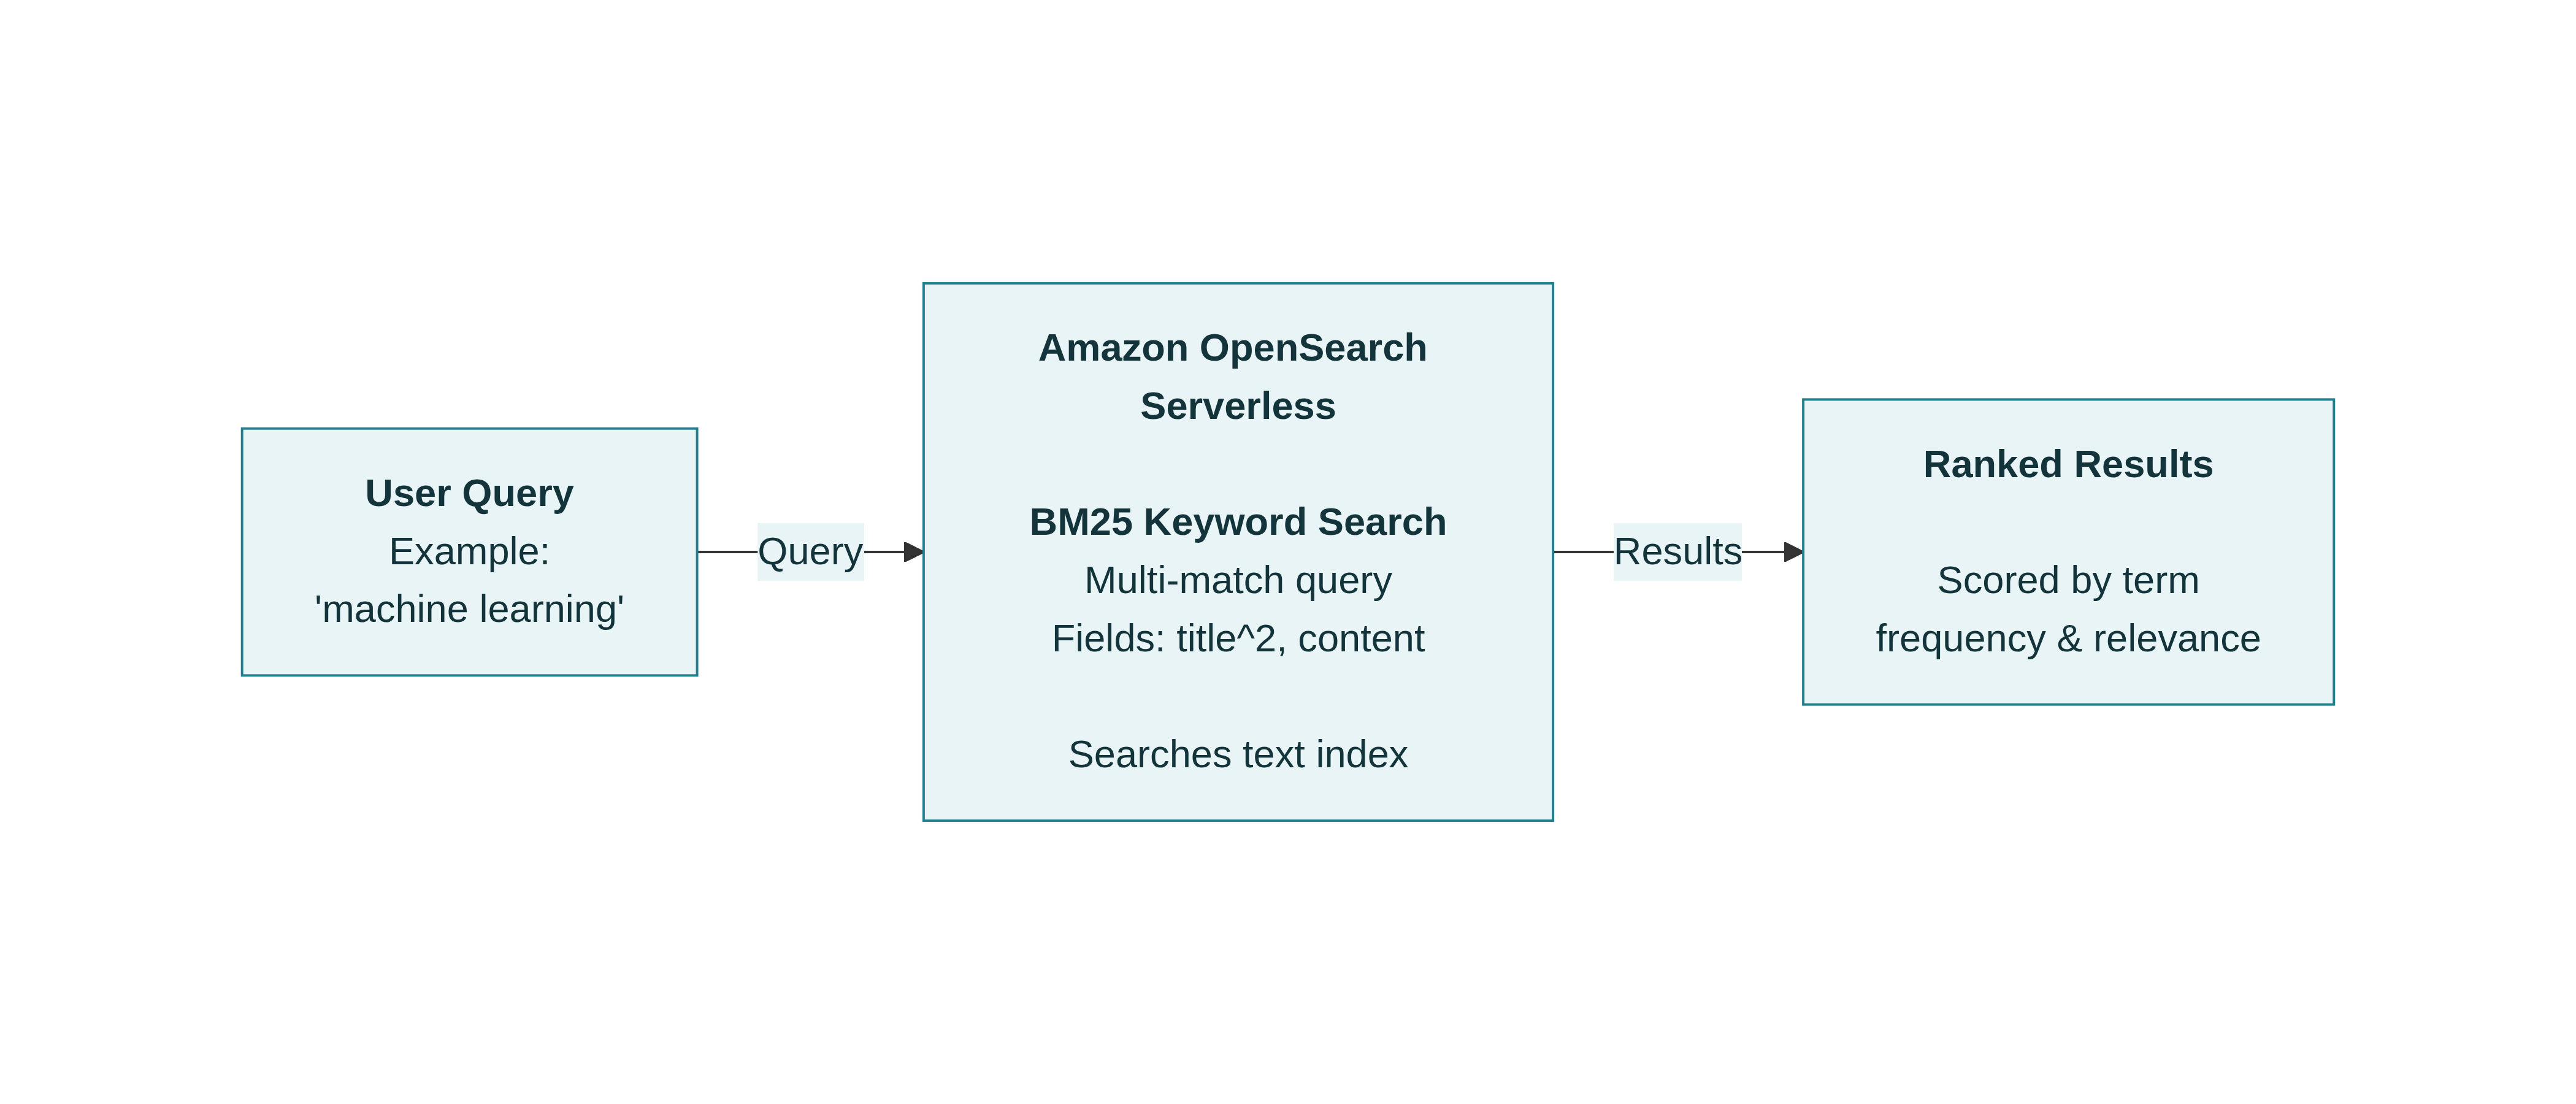

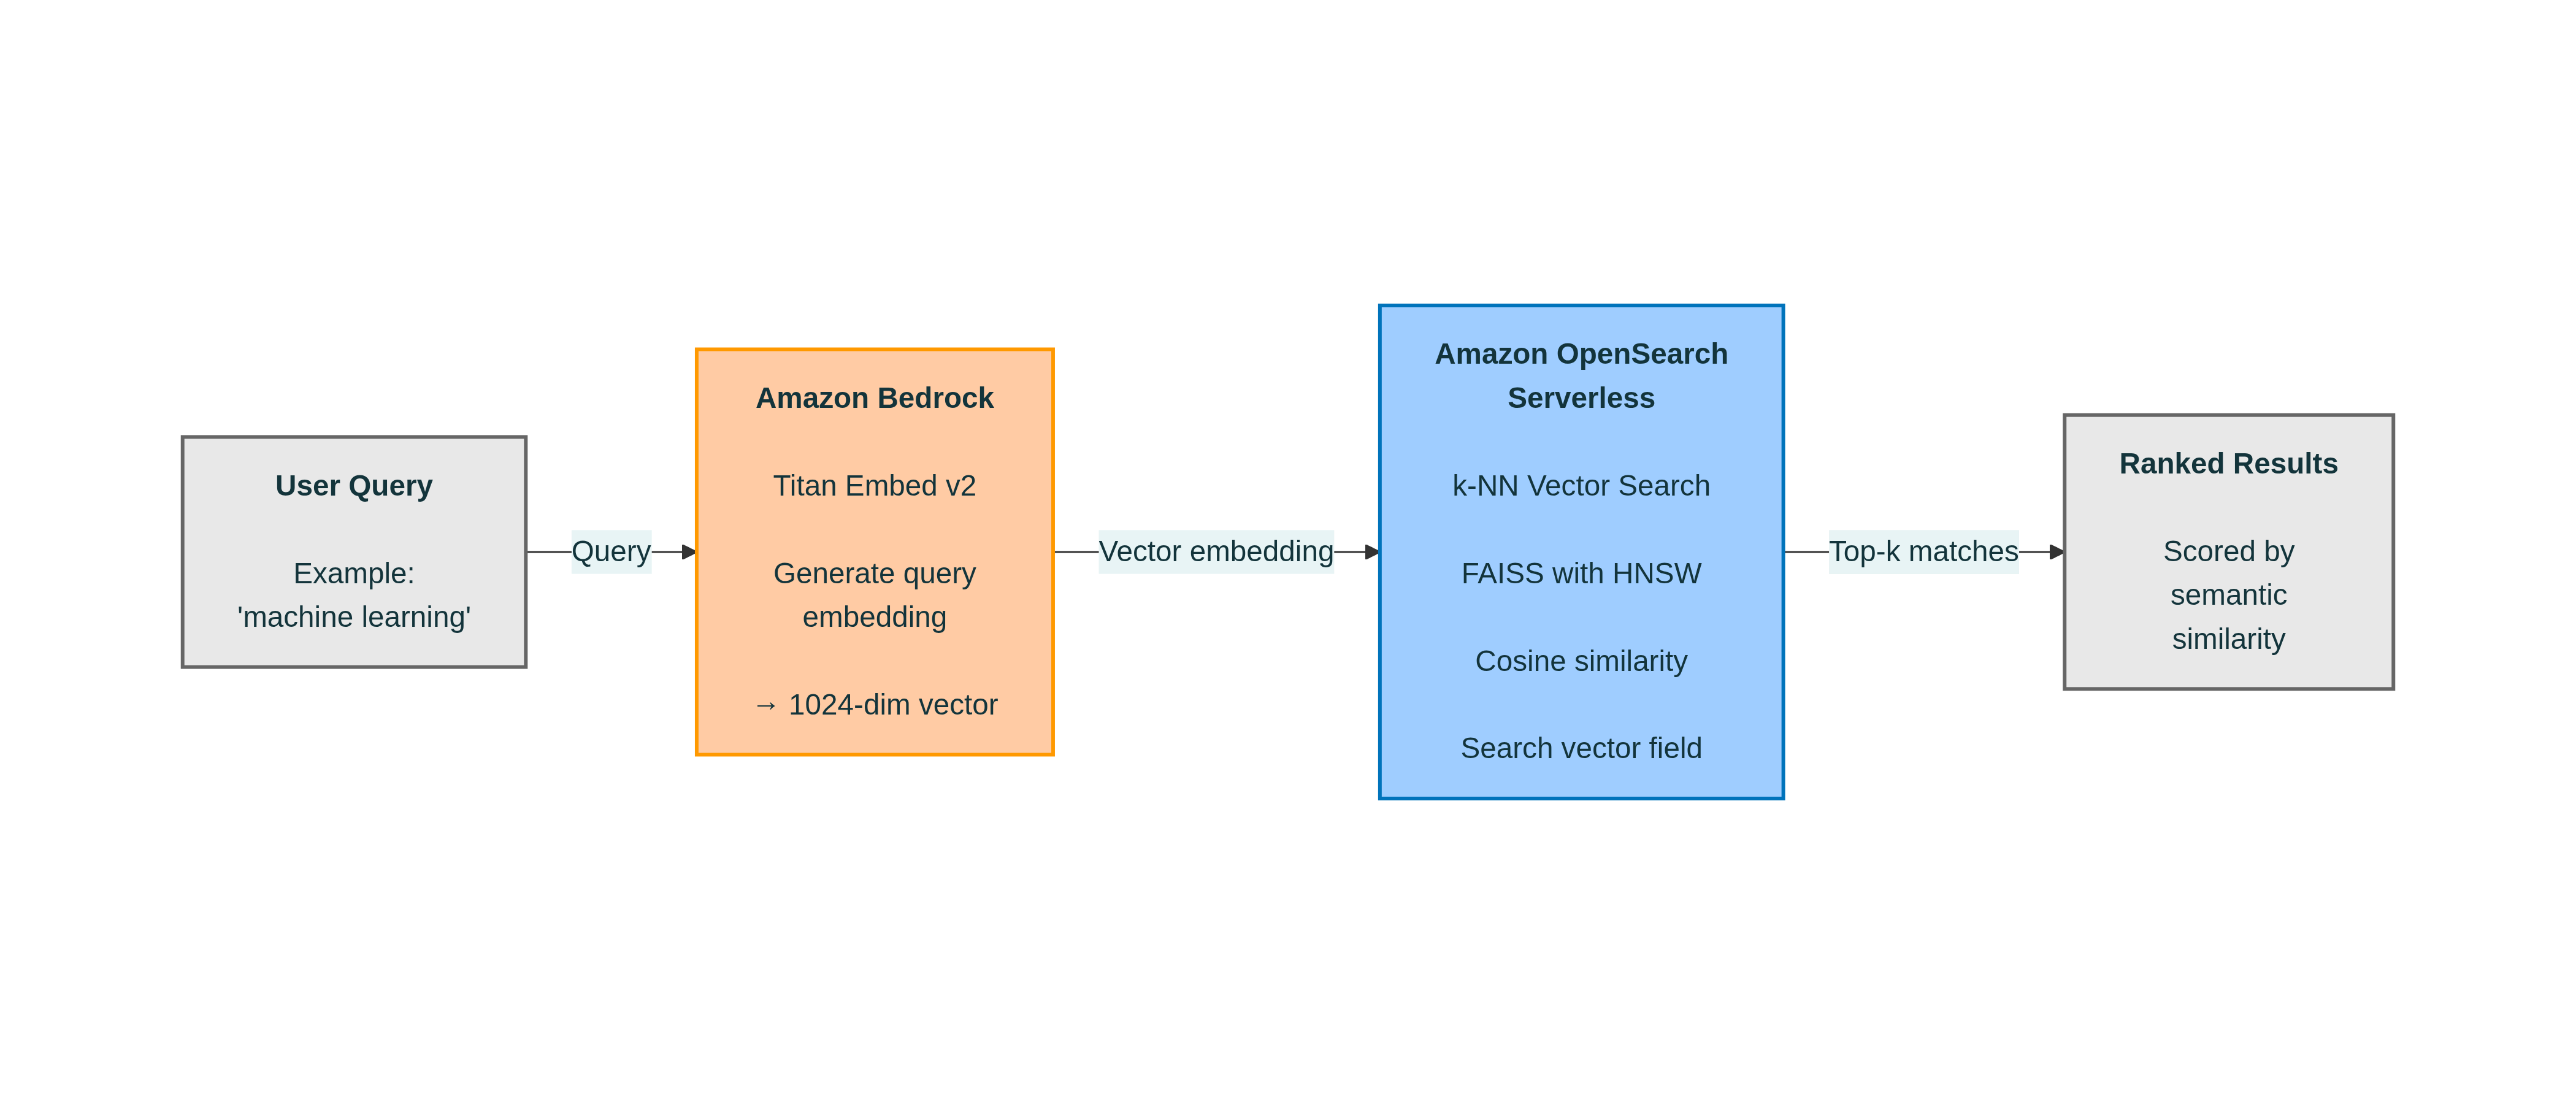

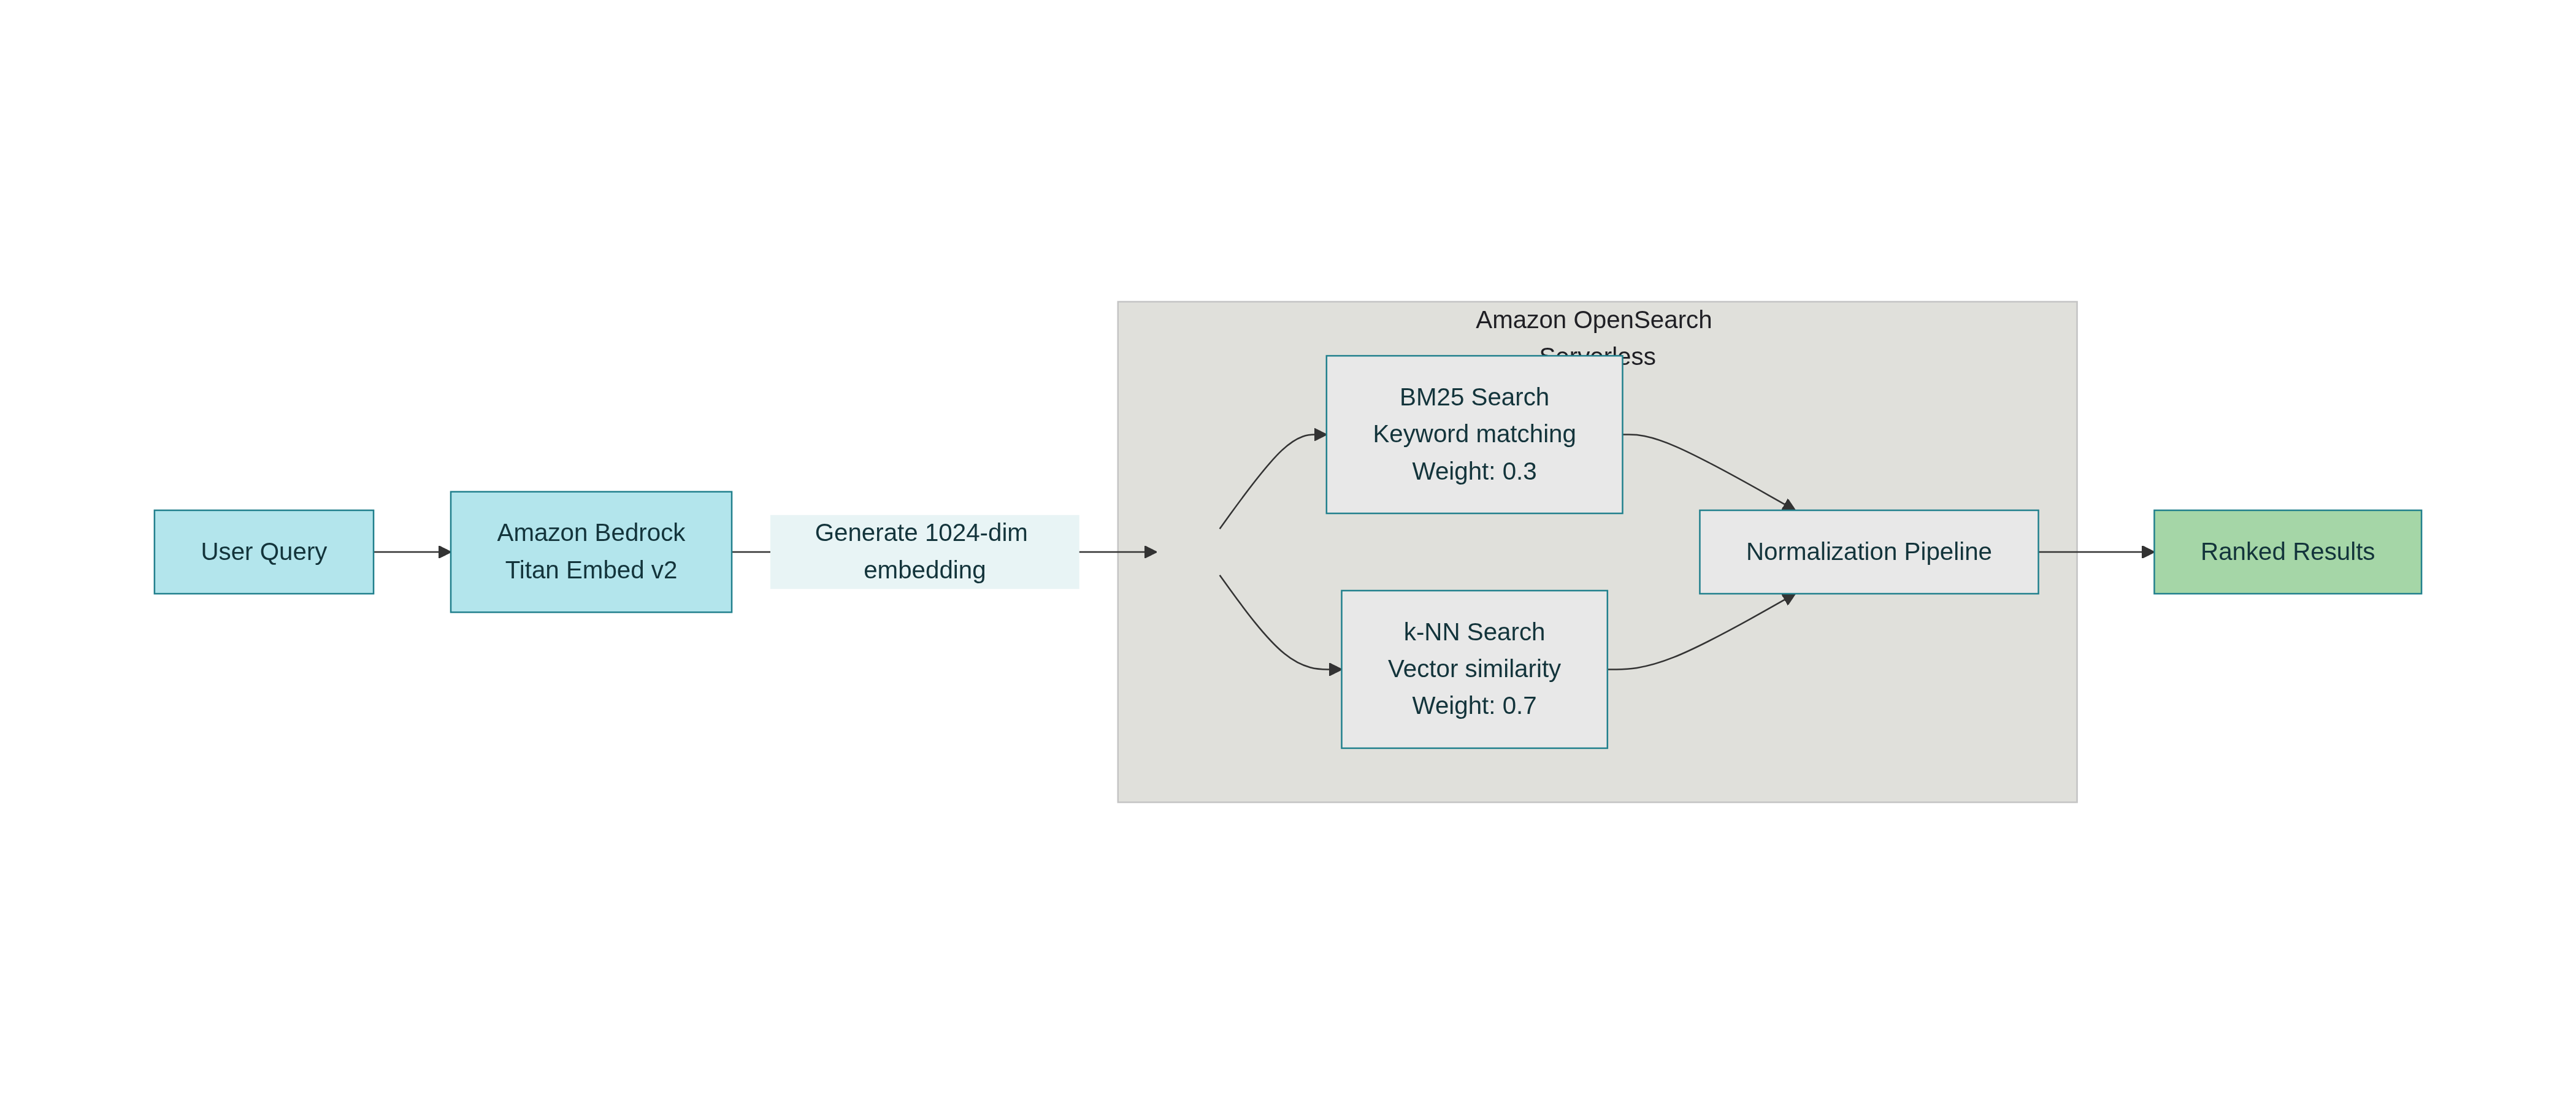

In [14]:
def bm25_search(query: str, size: int = 5):
    """Pure BM25 keyword search"""
    search_body = {
        "query": {
            "multi_match": {
                "query": query,
                "fields": ["title^2", "content"],
                "type": "best_fields"
            }
        },
        "size": size
    }
    
    response = client_oss.search(index=INDEX_NAME, body=search_body)
    return response['hits']['hits']

def vector_search(query: str, size: int = 5):
    """Pure k-NN vector search"""
    query_embedding = get_embedding(query)
    
    search_body = {
        "query": {
            "knn": {
                "vector": {
                    "vector": query_embedding,
                    "k": size
                }
            }
        },
        "size": size
    }
    
    response = client_oss.search(index=INDEX_NAME, body=search_body)
    return response['hits']['hits']

def hybrid_search(query: str, size: int = 5):
    """Hybrid search combining BM25 and k-NN"""
    query_embedding = get_embedding(query)
    
    search_body = {
        "query": {
            "hybrid": {
                "queries": [
                    {
                        "multi_match": {
                            "query": query,
                            "fields": ["title^2", "content"]
                        }
                    },
                    {
                        "knn": {
                            "vector": {
                                "vector": query_embedding,
                                "k": size
                            }
                        }
                    }
                ]
            }
        },
        "size": size
    }
    
    response = client_oss.search(
        index=INDEX_NAME, 
        body=search_body,
        params={"search_pipeline": pipeline_name}
    )
    return response['hits']['hits']

## 5. Compare Search Methods

In [15]:
def compare_searches(query: str):
    """Compare all three search methods"""
    print(f"\n=== Query: '{query}' ===")
    
    # BM25 Search
    print("\n--- BM25 (Keyword) Results ---")
    bm25_results = bm25_search(query, 3)
    for i, hit in enumerate(bm25_results, 1):
        score = hit['_score']
        title = hit['_source']['title']
        print(f"{i}. [Score: {score:.4f}] {title}")
    
    # Vector Search
    print("\n--- k-NN (Semantic) Results ---")
    vector_results = vector_search(query, 3)
    for i, hit in enumerate(vector_results, 1):
        score = hit['_score']
        title = hit['_source']['title']
        print(f"{i}. [Score: {score:.4f}] {title}")
    
    # Hybrid Search
    print("\n--- Hybrid (Combined) Results ---")
    hybrid_results = hybrid_search(query, 3)
    for i, hit in enumerate(hybrid_results, 1):
        score = hit['_score']
        title = hit['_source']['title']
        print(f"{i}. [Score: {score:.4f}] {title}")

# Test different query types
test_queries = [
    "machine learning embeddings",
    "semantic similarity search", 
    "Amazon Bedrock integration",
    "search relevance optimization"
]

for query in test_queries:
    compare_searches(query)


=== Query: 'machine learning embeddings' ===

--- BM25 (Keyword) Results ---
1. [Score: 7.2238] Machine Learning Embeddings
2. [Score: 3.0143] Vector Search Fundamentals

--- k-NN (Semantic) Results ---
1. [Score: 0.8925] Machine Learning Embeddings
2. [Score: 0.6856] Vector Search Fundamentals
3. [Score: 0.5854] Amazon Bedrock Integration

--- Hybrid (Combined) Results ---
1. [Score: 1.0000] Machine Learning Embeddings
2. [Score: 0.2476] Vector Search Fundamentals
3. [Score: 0.0281] Amazon Bedrock Integration

=== Query: 'semantic similarity search' ===

--- BM25 (Keyword) Results ---
1. [Score: 2.1907] Machine Learning Embeddings
2. [Score: 1.3863] Vector Search Fundamentals
3. [Score: 1.3863] OpenSearch Hybrid Search

--- k-NN (Semantic) Results ---
1. [Score: 0.7130] Search Relevance Optimization
2. [Score: 0.6851] Vector Search Fundamentals
3. [Score: 0.6846] OpenSearch Hybrid Search

--- Hybrid (Combined) Results ---
1. [Score: 0.7003] Search Relevance Optimization
2. [Score: 0.

## 6. Advanced Hybrid Query with Filters

In [17]:
def advanced_hybrid_search(query: str, category_filter: str = None, size: int = 5):
    """Hybrid search with metadata filtering"""
    query_embedding = get_embedding(query)
    
    # Separate BM25 and kNN queries
    bm25_query = {
        "multi_match": {
            "query": query,
            "fields": ["title^2", "text"]  # Use 'text' if that's your field name
        }
    }
    
    knn_query = {
        "knn": {
            "vector": {
                "vector": query_embedding,
                "k": size * 2
            }
        }
    }
    
    # Combine queries based on filter
    if category_filter:
        search_body = {
            "query": {
                "bool": {
                    "should": [
                        bm25_query,
                        knn_query
                    ],
                    "filter": [
                        {"term": {"category": category_filter}}
                    ],
                    "minimum_should_match": 1
                }
            },
            "size": size
        }
    else:
        search_body = {
            "query": {
                "bool": {
                    "should": [
                        bm25_query,
                        knn_query
                    ],
                    "minimum_should_match": 1
                }
            },
            "size": size
        }
    
    response = client_oss.search(
        index=INDEX_NAME,
        body=search_body,
        params={"search_pipeline": pipeline_name}
    )
    return response['hits']['hits']

# Test filtered search
print("\n=== Filtered Hybrid Search ===")
query = "machine learning"
results = advanced_hybrid_search(query, category_filter="AI")

print(f"Query: '{query}' (Category: AI)")
for i, hit in enumerate(results, 1):
    score = hit['_score']
    title = hit['_source'].get('title', 'N/A')
    category = hit['_source'].get('category', 'N/A')
    print(f"{i}. [Score: {score:.4f}] {title} ({category})")



=== Filtered Hybrid Search ===
Query: 'machine learning' (Category: AI)


## 7. RAG Implementation with Hybrid Search

In [20]:
def generate_response(query: str, context_docs: list) -> str:
    """Generate response using Bedrock"""
    context = "\n\n".join([
        f"Document {i+1}: {doc['_source']['title']}\n{doc['_source']['content']}"
        for i, doc in enumerate(context_docs)
    ])
    
    prompt = f"""Based on the following context, answer the question comprehensively.

Context:
{context}

Question: {query}

Answer:"""
    
    response = bedrock_runtime.invoke_model(
        modelId="amazon.nova-pro-v1:0",
        body=json.dumps({
            "messages": [{"role": "user", "content": [{"text": prompt}]}]
        })
    )
    
    return json.loads(response['body'].read())['output']['message']['content'][0]['text']

def hybrid_rag(query: str) -> tuple:
    """Complete RAG pipeline with hybrid search"""
    # Retrieve relevant documents
    search_results = hybrid_search(query, 3)
    
    # Generate response
    response = generate_response(query, search_results)
    
    return response, search_results

# Test RAG pipeline
question = "How does hybrid search improve search relevance compared to traditional methods?"

answer, sources = hybrid_rag(question)

print(f"\n=== RAG with Hybrid Search ===")
print(f"Question: {question}")
print(f"\nAnswer: {answer}")
print(f"\nSources:")
for i, source in enumerate(sources, 1):
    title = source['_source']['title']
    score = source['_score']
    print(f"{i}. [Score: {score:.4f}] {title}")


=== RAG with Hybrid Search ===
Question: How does hybrid search improve search relevance compared to traditional methods?

Answer: Hybrid search improves search relevance compared to traditional methods through the integration of two distinct but complementary techniques: BM25 keyword matching and k-Nearest Neighbors (k-NN) vector similarity. Here's a comprehensive explanation of how this combination enhances search relevance:

### 1. BM25 Keyword Matching
- **Definition**: BM25 is a bag-of-words retrieval function that ranks a set of documents based on the query terms appearing in each document.
- **Strengths**: 
  - Effective for capturing exact keyword matches and proximity.
  - Handles term frequency and inverse document frequency well, which helps in identifying documents that are statistically relevant to the query terms.
- **Limitations**: 
  - It may fail to capture the semantic meaning behind the words.
  - Synonyms and related terms might not be adequately addressed.

### 2.

## 8. Performance Analysis

In [19]:
import time

def benchmark_searches(query: str, iterations: int = 5):
    """Benchmark different search methods"""
    methods = {
        'BM25': bm25_search,
        'Vector': vector_search,
        'Hybrid': hybrid_search
    }
    
    results = {}
    
    for method_name, method_func in methods.items():
        times = []
        for _ in range(iterations):
            start_time = time.time()
            method_func(query, 3)
            end_time = time.time()
            times.append(end_time - start_time)
        
        avg_time = sum(times) / len(times)
        results[method_name] = avg_time
    
    print(f"\n=== Performance Benchmark (Query: '{query}') ===")
    for method, avg_time in results.items():
        print(f"{method}: {avg_time*1000:.2f}ms average")
    
    return results

# Run benchmark
benchmark_results = benchmark_searches("machine learning embeddings")


=== Performance Benchmark (Query: 'machine learning embeddings') ===
BM25: 159.27ms average
Vector: 390.57ms average
Hybrid: 386.13ms average


## 9. Cleanup Resources

In [ ]:
def cleanup():
    """Clean up OpenSearch resources"""
    try:
        # Delete search pipeline
        client.transport.perform_request(
            "DELETE",
            f"/_search/pipeline/{pipeline_name}"
        )
        print(f"Deleted search pipeline: {pipeline_name}")
        
        # Delete index
        client.indices.delete(INDEX_NAME)
        print(f"Deleted index: {INDEX_NAME}")
        
    except Exception as e:
        print(f"Cleanup error: {e}")

# Uncomment to cleanup
# cleanup()